### does training on clinvar predict disease better than single mpc? - cardiomyopathy
* rm testing data from clinvar

In [1]:
import pandas as pd
import numpy
from scipy.stats import entropy
import pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import HTML
%matplotlib inline

In [2]:
cols = ['mpc']
key_cols = ['chrom', 'pos', 'ref', 'alt']
ho = ['CorrectBenign', 'CorrectPath', 'WrongBenign', 'WrongPath']

right_benign = "#32CD32"
right_path = "#2ecc71"
wrong_path = "#e74c3c"
wrong_benign = "#ffcccb"
flatui = [right_benign, right_path, wrong_benign, wrong_path]

def eval_pred(row, col):
    if row[col] == row['y']:
        if row['y'] == 1:
            return 'CorrectPath'
        return 'CorrectBenign'
    if row['y'] == 1:
        return 'WrongPath'
    return 'WrongBenign'

def eval_mpc_raw(row):
    if row['y'] == 1:
        if row['mpc']>=float(2):
            return 'CorrectPath'
        return 'WrongPath'
    if row['mpc']>=float(2):
        return 'WrongBenign'
    return 'CorrectBenign'

In [3]:
# load clinvar
dat_file = '../data/interim/clinvar/clinvar.limit3.dat'
clinvar_df_pre = pd.read_csv(dat_file, sep='\t').rename(columns={'clin_class':'y'})

In [4]:
# other disease df: missense
dat_file = '../data/interim/other/other.eff.dbnsfp.anno.hHack.dat.limit.xls'
disease_df_pre = pd.read_csv(dat_file, sep='\t')
disease_df_pre.loc[:, 'y'] = disease_df_pre.apply(lambda row: 1 if row['class']=='P' else 0, axis=1)
disease = 'Cardiomyopathy'
disease_df = disease_df_pre[disease_df_pre.Disease==disease]
test_keys = {':'.join([str(x) for x in v]):True for v in disease_df[key_cols].values}
#tree_clf = tree.DecisionTreeClassifier(max_depth=1)
#X, y = train_df[cols], train_df['y']
#tree_clf.fit(X, y)
crit = clinvar_df_pre.apply(lambda row: not ':'.join([str(row[x]) for x in key_cols]) in test_keys, axis=1)
clinvar_df = clinvar_df_pre[crit]
print('clinvar w/o testing data', len(clinvar_df))

disease_genes = set(disease_df['gene'])
crit = clinvar_df.apply(lambda row: row['gene'] in disease_genes, axis=1)
clinvar_df_limit_genes = clinvar_df[crit]
print('clinvar w/o testing data for disease genes', len(clinvar_df_limit_genes))

clinvar w/o testing data 24140
clinvar w/o testing data for disease genes 1607


In [5]:
disease_panel_gene_count = len(set(disease_df['gene']))
print(disease, disease_panel_gene_count)
disease_df.groupby('y').size()

Cardiomyopathy 45


y
0    258
1    180
dtype: int64

In [6]:
# train clinvar
# apply mpc>2
tree_clf_clinvar = tree.DecisionTreeClassifier(max_depth=1)
X, y = clinvar_df[cols], clinvar_df['y']
tree_clf_clinvar.fit(X, y)

tree_clf_clinvar_limit_genes = tree.DecisionTreeClassifier(max_depth=1)
X, y = clinvar_df_limit_genes[cols], clinvar_df_limit_genes['y']
tree_clf_clinvar_limit_genes.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

,PredictionStatusMPC,size
0,CorrectBenign,235
1,CorrectPath,145
2,WrongBenign,23
3,WrongPath,35


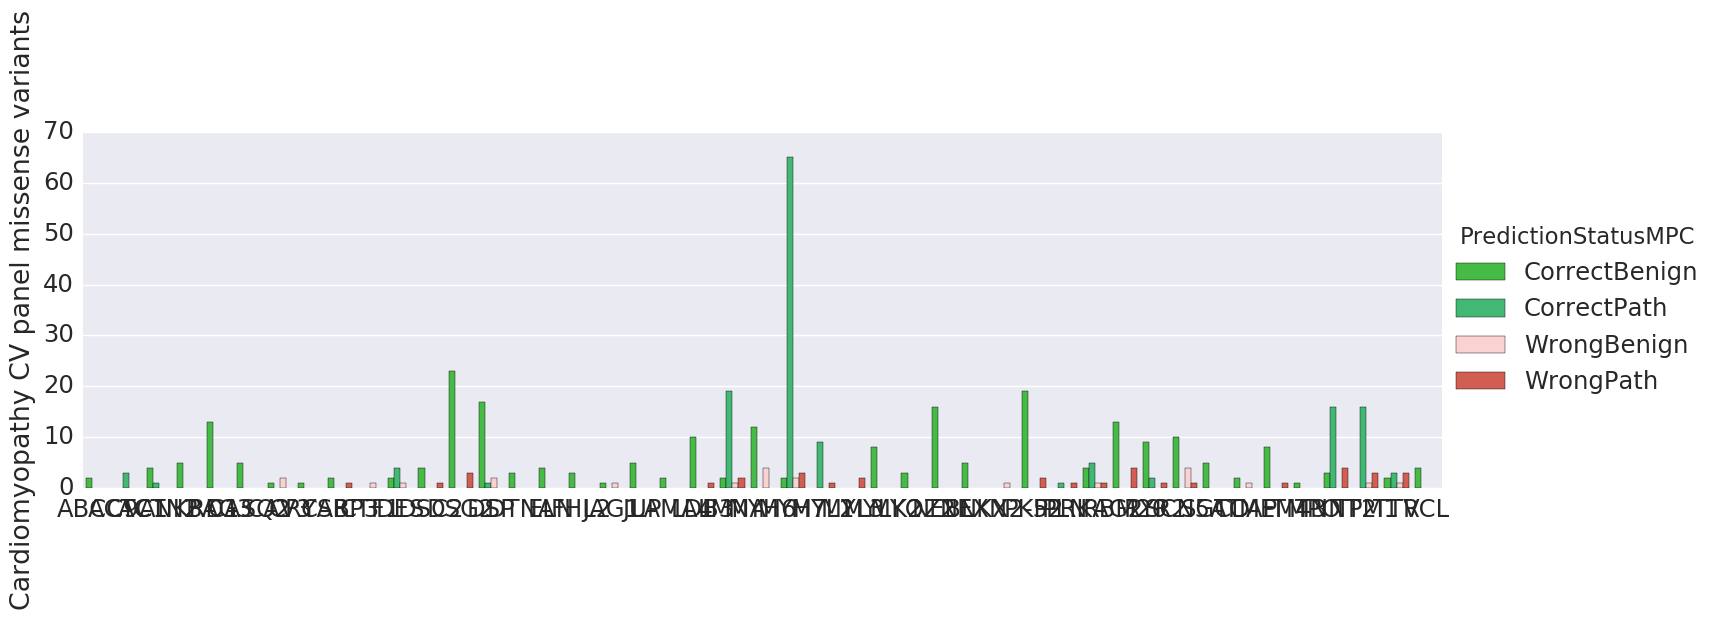

In [7]:
# one gene at a time
acc_df_ls = []
genes = set(disease_df['gene'])

tree_clf_clinvar = tree.DecisionTreeClassifier(max_depth=1)
X, y = clinvar_df[cols], clinvar_df['y']
tree_clf_clinvar.fit(X, y)
    
for test_gene in genes:
    sub_train_df = disease_df[disease_df.gene != test_gene]
    tree_clf_sub = tree.DecisionTreeClassifier(max_depth=1)
    X, y = sub_train_df[cols], sub_train_df['y']
    tree_clf_sub.fit(X, y)
    
    test_df = disease_df[disease_df.gene == test_gene]
    X_test = test_df[cols]
    preds = tree_clf_sub.predict(X_test)
    test_df['mpc_pred'] = preds
    test_df.loc[:, 'PredictionStatusMPC'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred'), axis=1)
    
    preds = tree_clf_clinvar.predict(X_test)
    test_df['mpc_pred_clinvar'] = preds
    test_df.loc[:, 'PredictionStatusMPC_clinvar'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred_clinvar'), axis=1)
    
    preds = tree_clf_clinvar_limit_genes.predict(X_test)
    test_df['mpc_pred_clinvar_limit_genes'] = preds
    test_df.loc[:, 'PredictionStatusMPC_clinvar_limit_genes'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred_clinvar_limit_genes'), axis=1)
    
    # apply mpc>=2
    test_df.loc[:, 'PredictionStatusMPC>2'] = test_df.apply(eval_mpc_raw, axis=1)
    
    acc_df_ls.append(test_df)

test_df = pd.concat(acc_df_ls)
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['gene', 'PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC', y='size', data=g_df, hue_order=ho,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('%s CV panel missense variants' % (disease,))
ss.set_xlabels('')
ss.set_titles('MPC performance')
#ss.savefig("../docs/plots/%s_cv_mpc_eval.png" % (disease,))

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()

,PredictionStatusMPC_clinvar,size
0,CorrectBenign,188
1,CorrectPath,159
2,WrongBenign,70
3,WrongPath,21


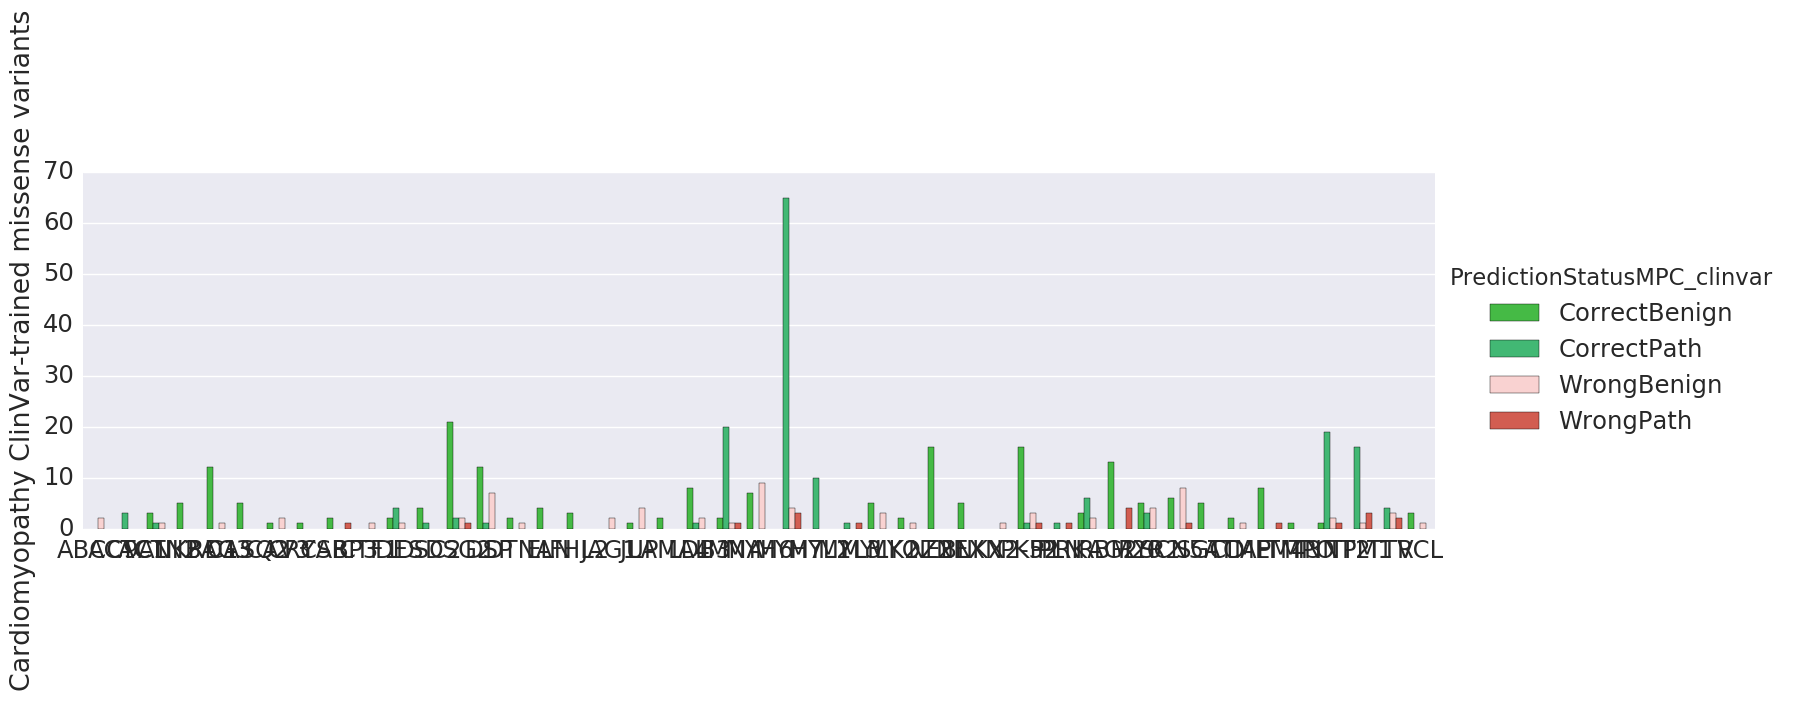

In [8]:
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC_clinvar']]
        .groupby(['gene', 'PredictionStatusMPC_clinvar'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC_clinvar', y='size', data=g_df, hue_order=ho,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('%s ClinVar-trained missense variants' % (disease,))
ss.set_xlabels('')
ss.set_titles('MPC performance')
#ss.savefig("../docs/plots/%s_cv_mpc_eval.png" % (disease,))

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC_clinvar']]
        .groupby(['PredictionStatusMPC_clinvar'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()

,PredictionStatusMPC_clinvar_limit_genes,size
0,CorrectBenign,166
1,CorrectPath,164
2,WrongBenign,92
3,WrongPath,16


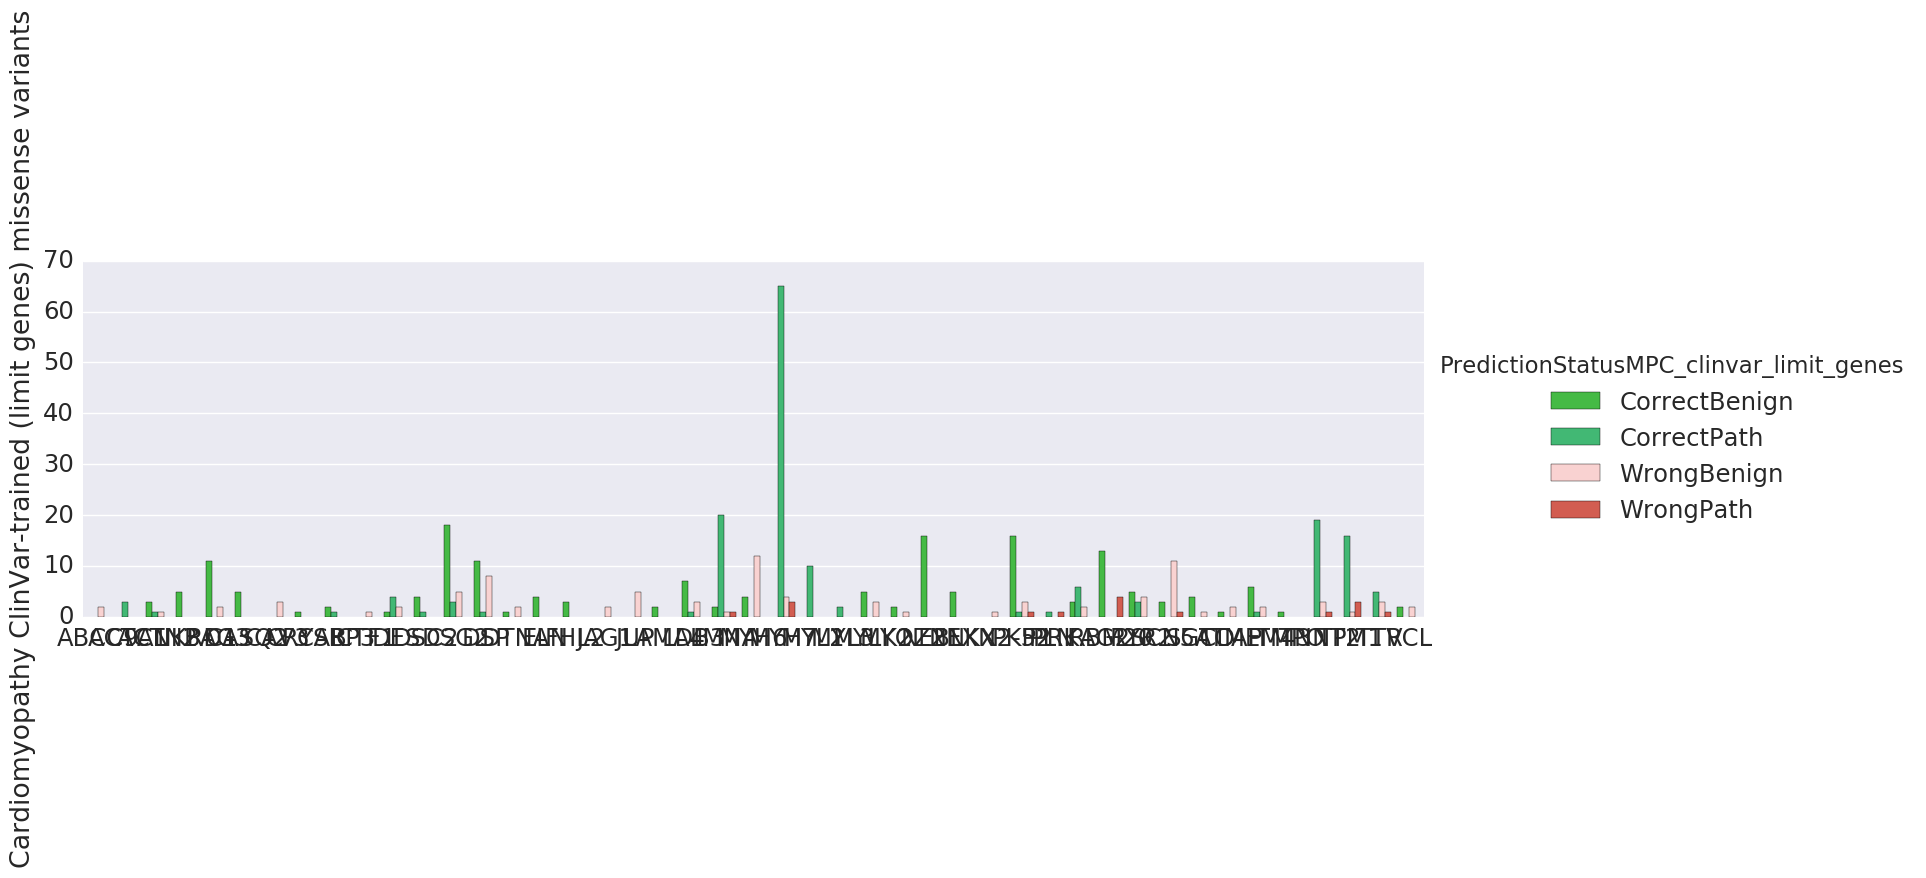

In [9]:
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC_clinvar_limit_genes']]
        .groupby(['gene', 'PredictionStatusMPC_clinvar_limit_genes'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC_clinvar_limit_genes', y='size', data=g_df, hue_order=ho,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('%s ClinVar-trained (limit genes) missense variants' % (disease,))
ss.set_xlabels('')
#ss.set_titles('MPC performance')
#ss.savefig("../docs/plots/%s_cv_mpc_eval.png" % (disease,))

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC_clinvar_limit_genes']]
        .groupby(['PredictionStatusMPC_clinvar_limit_genes'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()

,PredictionStatusMPC>2,size
0,CorrectBenign,257
1,CorrectPath,72
2,WrongBenign,1
3,WrongPath,108


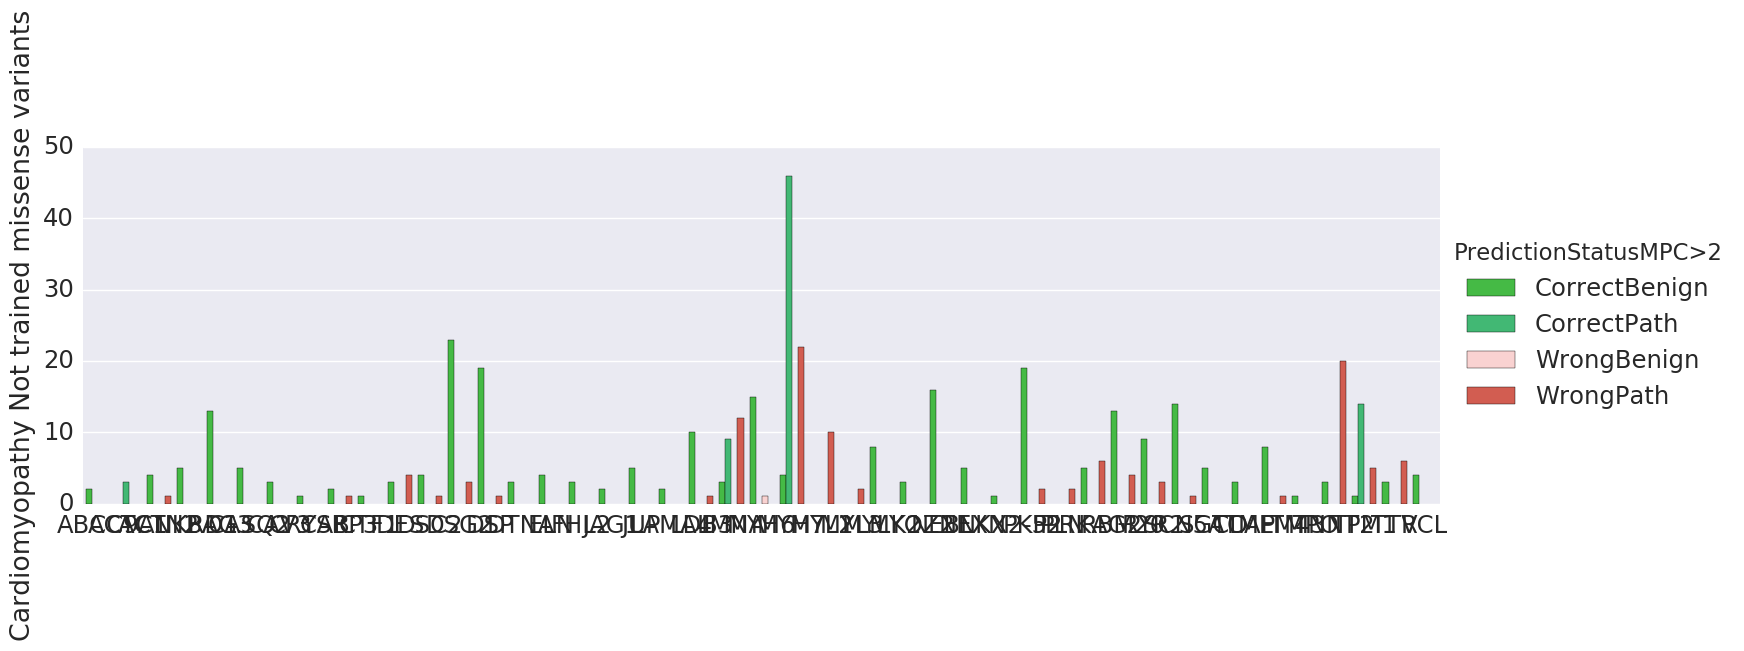

In [10]:
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC>2']]
        .groupby(['gene', 'PredictionStatusMPC>2'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC>2', y='size', data=g_df, hue_order=ho,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('%s Not trained missense variants' % (disease,))
ss.set_xlabels('')
ss.set_titles('MPC>2 performance')

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC>2']]
        .groupby(['PredictionStatusMPC>2'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()